<a href="https://colab.research.google.com/github/BeommoKoo-dev/recommender-system/blob/beommo/recommend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keybert
!pip install POT

In [4]:
from keybert import KeyBERT
import gensim
from gensim.models import KeyedVectors
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from gensim.models import LdaModel
from gensim import corpora
from sklearn.manifold import TSNE
from gensim.models import Word2Vec, KeyedVectors

# unused but required import for doing 3d projections with matplotlib < 3.2
# import mpl_toolkits.mplot3d  # noqa: F401
# from matplotlib import ticker

from sklearn import datasets, manifold
import json
import csv
import spacy
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore',category=UserWarning,module='keyedvectors')
warnings.filterwarnings(action='ignore',category=FutureWarning,module='keyedvectors')

In [5]:
### movie keyword extraction

movieCount = 200  # How many movies from .json
keywordCount = 15 # How many keywords for each movie

# Data Structures and Models
movies = []
synopsis = []
rows = []
kw_model = KeyBERT()
sp_model = spacy.load("en_core_web_sm")

# Reading .json
jsonFilePath = "movie_data.json"
with open(jsonFilePath, 'r', encoding='utf-8') as jsonFile:
    movieReader = (json.loads(line) for line in jsonFile)

    count = 0
    for movieData in movieReader:
        if count >= movieCount:
            break
        if count % 10 == 0:
            print(f'Reading File.. ({count}/{movieCount})')

        movieID = movieData.get('movie_id', '')
        movies.append(movieID)

        movieSummary = movieData.get('plot_synopsis', '')
        keywords = kw_model.extract_keywords(movieSummary, top_n=keywordCount)
        keyList = [keyword[0] for keyword in keywords]
        # extracting needless names
        filtered_keywords = []
        for keyword in keyList:
            doc = sp_model(keyword)
            is_name = any(token.ent_type_ == "PERSON" and token.ent_iob_ != '0' for token in doc)

            if not is_name:
                filtered_keywords.append(keyword)

        keyString = ', '.join(filtered_keywords)

        synopsis.append(keyString)

        count += 1

KeyboardInterrupt: ignored

In [6]:
# Writing .csv
csvFilePath = "movie_keyword_extraction_" + str(keywordCount) + ".csv"
with open(csvFilePath, 'w', newline='', encoding='utf-8') as csvFile:
    headers = ['MovieID', "Keywords"]
    writer = csv.DictWriter(csvFile, fieldnames=headers)
    writer.writeheader()

    for idx in range(0, movieCount):
        writer.writerow({'MovieID': movies[idx], 'Keywords': synopsis[idx]})

IndexError: ignored

In [86]:
### book keyword extraction

data = []
book_ids = []
book_summaries = []
synopsis = []
bookCount = 200
keywordCount = 15
kw_model = KeyBERT()
sp_model = spacy.load("en_core_web_sm")

with open('booksummaries.txt', 'r') as f:
    bookReader = csv.reader(f, dialect='excel-tab')
    count = 0
    for bookData in bookReader:
      if count >= bookCount :
        break
      if count % 10 == 0:
        print(f'Reading File.. ({count}/{bookCount})')

      data.append(bookData)
      count += 1

# convert data to pandas dataframe
books = pd.DataFrame.from_records(data, columns=['book_id', 'freebase_id', 'book_title', 'author', 'publication_date', 'genre', 'summary'])

Reading File.. (0/200)
Reading File.. (10/200)
Reading File.. (20/200)
Reading File.. (30/200)
Reading File.. (40/200)
Reading File.. (50/200)
Reading File.. (60/200)
Reading File.. (70/200)
Reading File.. (80/200)
Reading File.. (90/200)
Reading File.. (100/200)
Reading File.. (110/200)
Reading File.. (120/200)
Reading File.. (130/200)
Reading File.. (140/200)
Reading File.. (150/200)
Reading File.. (160/200)
Reading File.. (170/200)
Reading File.. (180/200)
Reading File.. (190/200)


In [7]:
book_ids = list(books['book_id'])
bookSummary = list(books['summary'])

NameError: ignored

In [88]:
count = 0

for book_idx in range(0, bookCount):
    if count >= bookCount:
        break
    if count % 10 == 0:
        print(f'Reading File.. ({count}/{bookCount})')

    keywords = kw_model.extract_keywords(bookSummary[book_idx], top_n=keywordCount)
    keyList = [keyword[0] for keyword in keywords]
    # extracting needless names
    filtered_keywords = []
    for keyword in keyList:
        doc = sp_model(keyword)
        is_name = any(token.ent_type_ == "PERSON" and token.ent_iob_ != '0' for token in doc)

        if not is_name:
            filtered_keywords.append(keyword)

    keyString = ', '.join(filtered_keywords)

    synopsis.append(keyString)

    count += 1

Reading File.. (0/200)
Reading File.. (10/200)
Reading File.. (20/200)
Reading File.. (30/200)
Reading File.. (40/200)
Reading File.. (50/200)
Reading File.. (60/200)
Reading File.. (70/200)
Reading File.. (80/200)
Reading File.. (90/200)
Reading File.. (100/200)
Reading File.. (110/200)
Reading File.. (120/200)
Reading File.. (130/200)
Reading File.. (140/200)
Reading File.. (150/200)
Reading File.. (160/200)
Reading File.. (170/200)
Reading File.. (180/200)
Reading File.. (190/200)


In [92]:
# Writing .csv
csvFilePath = "book_keyword_extraction_" + str(keywordCount) + ".csv"
with open(csvFilePath, 'w', newline='', encoding='utf-8') as csvFile:
    headers = ['BookId', "Keywords"]
    writer = csv.DictWriter(csvFile, fieldnames=headers)
    writer.writeheader()

    for idx in range(0, bookCount):
        writer.writerow({'BookId': book_ids[idx], 'Keywords': synopsis[idx]})

In [13]:
model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin', binary=True)

In [23]:
import csv
book_data = open("book_keyword_extraction_15.csv", "r")
movie_data = open("movie_keyword_extraction_15.csv", "r")

In [24]:
book_rdr = csv.reader(book_data)
movie_rdr = csv.reader(movie_data)

In [25]:
books = {book[0]:book[1].split(',') for book in book_rdr}
movies = {movie[0]:movie[1].split(',') for movie in movie_rdr}

In [29]:
def recommend_movie(book_id, recommend_count) :
  if book_id not in books :
    print("there is no book")
    return
  book_keyword = books[book_id]
  if len(book_keyword) == 0 :
    print("there is no book summarization")
    return
  res = []

  for movie_id, movie_keyword in movies.items() :
    if len(movie_keyword) == 0 :
      continue
    distance = model.wmdistance(book_keyword, movie_keyword)
    res.append({'movie_id' : movie_id, 'distance' : distance})

  sorted_res = sorted(res, key=lambda x: x['distance'])
  # print(sorted_res)
  return sorted_res[:recommend_count]


In [30]:
res = recommend_movie('620', 2)
print(res)

[{'movie_id': 'tt1872181', 'distance': 1.091564266316181}, {'movie_id': 'tt0388795', 'distance': 1.1472720195116062}]


In [31]:
def recommend_among_movies(movie_id, recommend_count) :
  movie_keyword = movies[movie_id]
  res = []

  for comp_movie_id, comp_movie_keyword in movies.items() :
    if len(comp_movie_keyword) == 0 :
      continue
    if movie_id == comp_movie_id :
      continue
    distance = model.wmdistance(movie_keyword, comp_movie_keyword)
    res.append({'movie_id' : comp_movie_id, 'distance' : distance})

  sorted_res = sorted(res, key=lambda x: x['distance'])
  # print(sorted_res)
  return sorted_res[:recommend_count]

In [32]:
recommend_among_movies('tt0450259', 5)

[{'movie_id': 'tt0120794', 'distance': 1.1201891688829348},
 {'movie_id': 'tt1798603', 'distance': 1.1279016737606011},
 {'movie_id': 'tt0458352', 'distance': 1.1410306627941527},
 {'movie_id': 'tt0120586', 'distance': 1.1427710488040026},
 {'movie_id': 'tt1120985', 'distance': 1.1444454559896178}]

In [35]:
def show_similarity(book_id, movie_id) :
  book_keyword = books[book_id]
  movie_keyword = movies[movie_id]

  # 두 키워드 리스트를 합칩니다.
  all_keywords = book_keyword + movie_keyword

  # Word2Vec 모델을 초기화합니다.
  visualize_model = Word2Vec([all_keywords], vector_size=100, window=5, min_count=1, sg=1)
  # 합쳐진 키워드 리스트에 대한 각 키워드의 벡터를 가져옵니다.
  keyword_vectors = np.array([visualize_model.wv[keyword] for keyword in all_keywords])

  # t-SNE를 사용하여 키워드 간의 유사도를 시각화합니다 (2차원).
  tsne = TSNE(n_components=2, random_state=42)
  embeddings_2d = tsne.fit_transform(keyword_vectors)

  # 시각화
  plt.figure(figsize=(10, 6))
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='blue')

  # 각 데이터 포인트에 해당하는 키워드와 유사도 레이블을 추가합니다.
  for i, keyword in enumerate(all_keywords):
    x, y = embeddings_2d[i]
    plt.annotate(f'{keyword} : {visualize_model.wv.similarity(keyword, all_keywords[0]):.2f}', (x, y))

  plt.show()

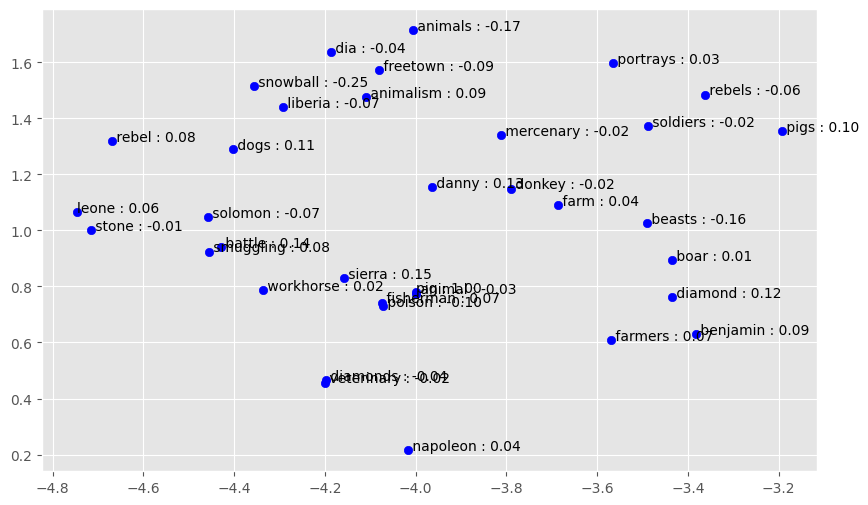

In [36]:
show_similarity('620', 'tt0450259')